In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
pip install torch torchvision pycocotools opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 427.8/427.8 kB 8.7 MB/s eta 0:00:00:00:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import cv2
import json
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import ast

In [3]:
# Dataset class
class DeepFashion2SegmentationDataset(Dataset):
    def __init__(self, csv_file, image_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.image_dir = image_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        # Extract data for the current item
        img_path = self.data.loc[idx, 'path']
        img_full_path = os.path.join(self.image_dir, os.path.basename(img_path))
        segmentation = self.data.loc[idx, 'segmentation']
        
        # Load image
        image = cv2.imread(img_full_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Create a blank mask with the same dimensions as the image
        mask = np.zeros((image.shape[0], image.shape[1]), dtype=np.float32)  # Ensure dtype is float32

        
        # Parse the segmentation string into a list of polygons
        polygons = ast.literal_eval(segmentation)
        
        # Fill mask as before
        for poly in polygons:
            points = np.array(poly).reshape(-1, 2).astype(np.int32)
            cv2.fillPoly(mask, [points], color=1.0)

        # Transform the image and mask to tensors if specified
        if self.transform:
            image = self.transform(image)
            mask = ToTensor()(mask).float()
            
        
        return image, mask.squeeze(0)

# Display a sample image and mask for verification
def display_sample(dataset, index):
    image, mask = dataset[index]
    print(image.shape, mask.shape)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    ax1.imshow(image.permute(1, 2, 0).numpy())
    ax1.set_title('Original Image')
    ax2.imshow(mask.squeeze().numpy(), cmap='gray')
    ax2.set_title('Segmentation Mask')
    plt.show()



In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        
        
        self.encoder1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
        )
        
        self.encoder2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
        )
        
        self.encoder3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
        )

        self.encoder4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
        )
        
        # Bottleneck
        self.bottleneck = nn.Sequential(
            nn.Conv2d(512, 1024, kernel_size=3, padding=1),
            nn.Conv2d(1024, 1024, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        
        # Expanding path (Decoder)
        self.decoder4 = nn.Sequential(
            nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )
        
        self.decoder3 = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )
        
        self.decoder2 = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )
        
        self.decoder1 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 1, kernel_size=3, padding=1)
        )
        
    
    def forward(self, x):
        # Encoder part
        # x = self.encoder(x)
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(enc1)
        enc3 = self.encoder3(enc2)
        enc4 = self.encoder4(enc3)
        
        # Bottleneck part
        bottleneck = self.bottleneck(enc4)
        
        # Decoder part
        dec4 = self.decoder4(bottleneck)
        dec3 = self.decoder3(dec4)
        dec2 = self.decoder2(dec3)
        dec1 = self.decoder1(dec2)
        # x = self.decoder(dec1)
        
        return torch.sigmoid(dec1)


In [ ]:
import torch

def calculate_accuracy(outputs, masks, threshold=0.5):
    """
    Calculate the accuracy for binary segmentation.
    Args:
        outputs (torch.Tensor): Model outputs after sigmoid activation.
        masks (torch.Tensor): Ground truth masks.
        threshold (float): Threshold for converting probabilities to binary values.
    Returns:
        float: Accuracy for the batch.
    """
    outputs = (outputs > threshold).float()  # Convert probabilities to binary predictions
    correct = (outputs == masks).sum().item()
    total = masks.numel()
    return correct / total

def training(
    model, optimizer, criterion, train_loader, val_loader, device, 
    save_path="unet_model", num_epochs=10
):
    model.to(device)  # Move model to the specified device
    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []

    print("Training started")

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0

        for images, masks in train_loader:
            images, masks = images.to(device), masks.to(device).float().unsqueeze(1)

            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)

            # Compute loss
            loss = criterion(outputs, masks)
            train_loss += loss.item()

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Calculate accuracy
            train_correct += (torch.sigmoid(outputs) > 0.5).eq(masks).sum().item()
            train_total += masks.numel()

        train_losses.append(train_loss / len(train_loader))
        train_accuracies.append(train_correct / train_total)

        # Validation phase
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(device), masks.to(device).float().unsqueeze(1)

                # Forward pass
                outputs = model(images)

                # Compute loss
                loss = criterion(outputs, masks)
                val_loss += loss.item()

                # Calculate accuracy
                val_correct += (torch.sigmoid(outputs) > 0.5).eq(masks).sum().item()
                val_total += masks.numel()

        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(val_correct / val_total)

        print(
            f'Epoch {epoch + 1}/{num_epochs}, '
            f'Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1]:.4f}, '
            f'Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracies[-1]:.4f}'
        )
        # Set the model back to training mode
        model.train()
    # Save the final trained model
    final_path = f"{save_path}_final.pth"
    torch.save(model.state_dict(), final_path)
    print(f"Final model saved to {final_path}")

    return train_losses, train_accuracies, val_losses, val_accuracies


In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import h5py

# Modify forward pass in the training function
def training(model, optimizer, criterion, train_loader, val_loader, device, 
    save_path="unet_model", num_epochs=10
):
    """
    Train the model and validate at each epoch, saving accuracy and loss.

    Args:
        model: PyTorch model to train.
        optimizer: Optimizer for the model.
        criterion: Loss function.
        train_loader: DataLoader for training data.
        val_loader: DataLoader for validation data.
        device: Device for computation.
        save_path: Path prefix for saving the model.
        num_epochs: Number of epochs to train.
    """
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    model.train()  # Set the model to training mode
    print("Training started")

    for epoch in range(num_epochs):
        # Track training loss and accuracy
        train_loss, train_correct, train_total = 0, 0, 0
        
        for images, masks in train_loader:
            # Move data to the specified device
            images, masks = images.to(device), masks.to(device).float().unsqueeze(1)  # Ensure masks have shape [B, 1, H, W]
            
            # Zero out gradients from the previous batch
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            predictions = (torch.sigmoid(outputs) > 0.5).float()  # Convert outputs to binary predictions

            # Compute loss
            loss = criterion(outputs, masks)
            train_loss += loss.item()

            # Compute accuracy
            train_correct += (predictions == masks).sum().item()
            train_total += masks.numel()

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

        # Compute average training loss and accuracy
        train_losses.append(train_loss / len(train_loader))
        train_accuracies.append(train_correct / train_total)

        # Validation step
        model.eval()  # Set the model to evaluation mode
        val_loss, val_correct, val_total = 0, 0, 0
        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(device), masks.to(device).float().unsqueeze(1)

                # Forward pass
                outputs = model(images)
                predictions = (torch.sigmoid(outputs) > 0.5).float()  # Convert outputs to binary predictions

                # Compute loss
                val_loss += criterion(outputs, masks).item()

                # Compute accuracy
                val_correct += (predictions == masks).sum().item()
                val_total += masks.numel()

        # Compute average validation loss and accuracy
        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(val_correct / val_total)
         # Print epoch metrics
        print(
            f"Epoch {epoch + 1}/{num_epochs}, "
            f"Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1]:.4f}, "
            f"Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracies[-1]:.4f}"
        )

        # Set the model back to training mode
        model.train()

    # Save the final trained model
    final_path = f"{save_path}_final.pth"
    torch.save(model.state_dict(), final_path)
    print(f"Final model saved to {final_path}")

    return train_losses, train_accuracies, val_losses, val_accuracies


In [6]:
import torch

def calculate_accuracy(outputs, masks, threshold=0.5):
    """
    Calculate the accuracy for binary segmentation.
    Args:
        outputs (torch.Tensor): Model outputs after sigmoid activation (probabilities).
        masks (torch.Tensor): Ground truth masks.
        threshold (float): Threshold for converting probabilities to binary values.
    Returns:
        float: Accuracy for the batch.
    """
    # Threshold probabilities to binary predictions
    predictions = (outputs > threshold).float()
    # Compare predictions with ground truth
    correct = (predictions == masks).sum().item()
    total = masks.numel()
    return correct / total


def training(
    model, optimizer, criterion, train_loader, val_loader, device, 
    save_path="unet_model", num_epochs=10
):
    """
    Train the UNet model for binary segmentation.
    Args:
        model: The UNet model to train.
        optimizer: Optimizer for training.
        criterion: Loss function for binary segmentation.
        train_loader: DataLoader for training data.
        val_loader: DataLoader for validation data.
        device: Device to train the model on (CPU or GPU).
        save_path: Path to save the trained model.
        num_epochs: Number of epochs to train the model.
    Returns:
        Tuple of training and validation losses and accuracies over epochs.
    """
    model.to(device)  # Move model to the specified device
    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []

    print("Training started")

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0

        for images, masks in train_loader:
            # Move inputs and targets to the device
            images = images.to(device)
            masks = masks.to(device).float().unsqueeze(1)  # Ensure masks are 4D (N, 1, H, W)

            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)  # Outputs are probabilities (sigmoid applied in the model)

            # Compute loss
            loss = criterion(outputs, masks)
            train_loss += loss.item()

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Calculate batch accuracy
            train_correct += (outputs > 0.5).eq(masks).sum().item()  # No sigmoid here
            train_total += masks.numel()

        train_losses.append(train_loss / len(train_loader))
        train_accuracies.append(train_correct / train_total)

        # Validation phase
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for images, masks in val_loader:
                # Move inputs and targets to the device
                images = images.to(device)
                masks = masks.to(device).float().unsqueeze(1)  # Ensure masks are 4D (N, 1, H, W)

                # Forward pass
                outputs = model(images)  # Outputs are probabilities (sigmoid applied in the model)

                # Compute loss
                loss = criterion(outputs, masks)
                val_loss += loss.item()

                # Calculate batch accuracy
                val_correct += (outputs > 0.5).eq(masks).sum().item()  # No sigmoid here
                val_total += masks.numel()

        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(val_correct / val_total)

        # Print metrics for the epoch
        print(
            f'Epoch {epoch + 1}/{num_epochs}, '
            f'Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1]:.4f}, '
            f'Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracies[-1]:.4f}'
        )

    # Save the final trained model
    final_path = f"{save_path}_final.pth"
    torch.save(model.state_dict(), final_path)
    print(f"Final model saved to {final_path}")

    return train_losses, train_accuracies, val_losses, val_accuracies


In [7]:



# Visualization function
def visualize(dataloader, model, device):
    """
    Visualize predictions from the model.
    
    Args:
        dataloader: DataLoader for the validation or test data.
        model: Trained PyTorch model.
        device: Device to use for inference.
    """
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        for images, masks in dataloader:
            images, masks = images.to(device), masks.to(device).unsqueeze(1)  # Ensure masks have shape [B, 1, H, W]
            outputs = torch.sigmoid(model(images))  # Apply sigmoid to get probabilities
            
            for i in range(len(images)):
                plt.figure(figsize=(15, 5))
                
                # Original Image
                plt.subplot(1, 3, 1)
                plt.imshow(images[i].cpu().permute(1, 2, 0).numpy())  # Move back to CPU
                plt.title("Original Image")

                # Ground Truth Mask
                plt.subplot(1, 3, 2)
                plt.imshow(masks[i].cpu().squeeze().numpy(), cmap='gray')  # Move back to CPU
                plt.title("Ground Truth Mask")

                # Predicted Mask
                plt.subplot(1, 3, 3)
                plt.imshow((outputs[i].cpu().squeeze().numpy() > 0.5).astype(int), cmap='gray')  # Threshold to binary
                plt.title("Predicted Mask")

                plt.show()
            break

# Display a sample from the dataset
def display_sample(dataset, idx):
    """
    Display a sample image and mask from the dataset.
    
    Args:
        dataset: Instance of the dataset.
        idx: Index of the sample to display.
    """
    image, mask = dataset[idx]
    plt.figure(figsize=(10, 5))

    # Original Image
    plt.subplot(1, 2, 1)
    plt.imshow(image.permute(1, 2, 0))  # Permute to HWC for display
    plt.title("Original Image")

    # Ground Truth Mask
    plt.subplot(1, 2, 2)
    plt.imshow(mask.squeeze(), cmap='gray')
    plt.title("Ground Truth Mask")

    plt.show()


In [ ]:
torch.cuda.empty_cache()


In [ ]:
from torch.utils.data import random_split
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset, DataLoader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Dataset preparation
csv_file = '/kaggle/input/deepfashion2-256x256/DeepFashion2 Resized/input/validation.csv'  # Update as per your CSV file name
image_dir = '/kaggle/input/deepfashion2-256x256/DeepFashion2 Resized/resized/validation'
transform = ToTensor()

# Load the full dataset
dataset = DeepFashion2SegmentationDataset(csv_file=csv_file, image_dir=image_dir, transform=transform)

dataset_indices = list(range(len(dataset)))
# train_indices, val_indices = train_test_split(
#     dataset_indices, test_size=0.25, random_state=41  # 80% train, 20% validation
# )

train_indices, val_indices = train_test_split(
    dataset_indices, test_size=0.95, random_state=11  # 80% train, 20% validation
)

val_indices, test_indices = train_test_split(
    val_indices, test_size=0.95, random_state=42  # 80% train, 20% validation
)
# Create subsets using the indices
train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)
print("Training dataset image count", len(train_indices))
print("Validation dataset image count", len(val_indices))



# DataLoader for training and validation datasets
batch_size = 8  # Adjust based on your GPU memory
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

# Model initialization
model = UNet().to(device)

# Loss and optimizer
criterion = nn.BCEWithLogitsLoss()  # For binary segmentation
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Display a sample from the training set
display_sample(train_dataset, 0)

# Train the model
# train_losses, train_accuracies, val_losses, val_accuracies = training(
#     model, optimizer, criterion, train_loader, val_loader, device, save_path="/kaggle/working/modelUnet", num_epochs=2
# )

train_losses, train_accuracies, val_losses, val_accuracies = training(
    model=model,
    optimizer=torch.optim.Adam(model.parameters(), lr=0.001),
    criterion=torch.nn.BCELoss(),  # Use BCELoss since sigmoid is already applied
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    save_path="unet_binary_segmentation",
    num_epochs=2
)

# Visualize the results
visualize(val_loader, model, device)


**Prediciton**

In [16]:
import os
import csv
from torchvision.transforms import ToTensor
from PIL import Image
import matplotlib.pyplot as plt
import torch

def predict_single_image(image_path, model, device):
    """
    Predict the segmentation mask for a single image using the trained model.

    Args:
        image_path (str): Path to the input image.
        model (torch.nn.Module): Trained model.
        device (torch.device): Device to run inference on (CPU/GPU).

    Returns:
        original_image (PIL.Image): Original input image.
        predicted_mask (numpy.array): Predicted segmentation mask.
    """
    # Load and preprocess the image
    original_image = Image.open(image_path).convert("RGB")
    transform = ToTensor()
    input_tensor = transform(original_image).unsqueeze(0).to(device)  # Add batch dimension

    # Switch model to evaluation mode
    model.eval()
    with torch.no_grad():
        # Make prediction
        output = model(input_tensor)
    
    # Post-process the output
    predicted_mask = (output.squeeze().cpu().numpy() > 0.5).astype('uint8')  # Threshold at 0.5
    return original_image, predicted_mask

def save_predictions_to_csv(predictions, output_csv_path):
    """
    Save predictions to a CSV file.

    Args:
        predictions (list): List of tuples (image_name, predicted_mask_path).
        output_csv_path (str): Path to save the CSV file.
    """
    with open(output_csv_path, mode="w", newline="") as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(["Image Name", "Predicted Mask Path"])
        writer.writerows(predictions)

def process_images_in_directory(input_dir, output_dir, model, device):
    """
    Process all images in a directory and save the predictions.

    Args:
        input_dir (str): Path to the directory containing test images.
        output_dir (str): Path to the directory to save predicted masks.
        model (torch.nn.Module): Trained model.
        device (torch.device): Device to run inference on (CPU/GPU).

    Returns:
        predictions (list): List of tuples (image_name, predicted_mask_path).
    """
    os.makedirs(output_dir, exist_ok=True)
    predictions = []

    for image_name in os.listdir(input_dir):
        image_path = os.path.join(input_dir, image_name)
        output_mask_path = os.path.join(output_dir, f"{os.path.splitext(image_name)[0]}_mask.png")

        # Skip non-image files
        if not image_name.lower().endswith(('.png', '.jpg', '.jpeg')):
            continue

        # Predict the segmentation mask
        _, predicted_mask = predict_single_image(image_path, model, device)

        # Save the predicted mask as an image
        predicted_mask_image = Image.fromarray((predicted_mask * 255).astype('uint8'))
        predicted_mask_image.save(output_mask_path)

        predictions.append((image_name, output_mask_path))

    return predictions

# Model path and device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_path = "/kaggle/working/modelUnet_final.pth"  # Update with the correct path to your trained model
model = UNet().to(device)  # Ensure UNet is defined in your script
model.load_state_dict(torch.load(model_path, map_location=device))

# Directories
input_directory = "/kaggle/input/deepfashion2-256x256/DeepFashion2 Resized/resized/test"  # Replace with your directory of test images
output_directory = "/kaggle/output"  # Replace with your desired output directory
output_csv = "/kaggle/outputpredict.csv"  # Path to save the CSV file

# Process images and save results
predictions = process_images_in_directory(input_directory, output_directory, model, device)
save_predictions_to_csv(predictions, output_csv)

print(f"Predictions saved to {output_csv}")


/tmp/ipykernel_30/2452461232.py:88: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


Predictions saved to /kaggle/outputpredictions.csv


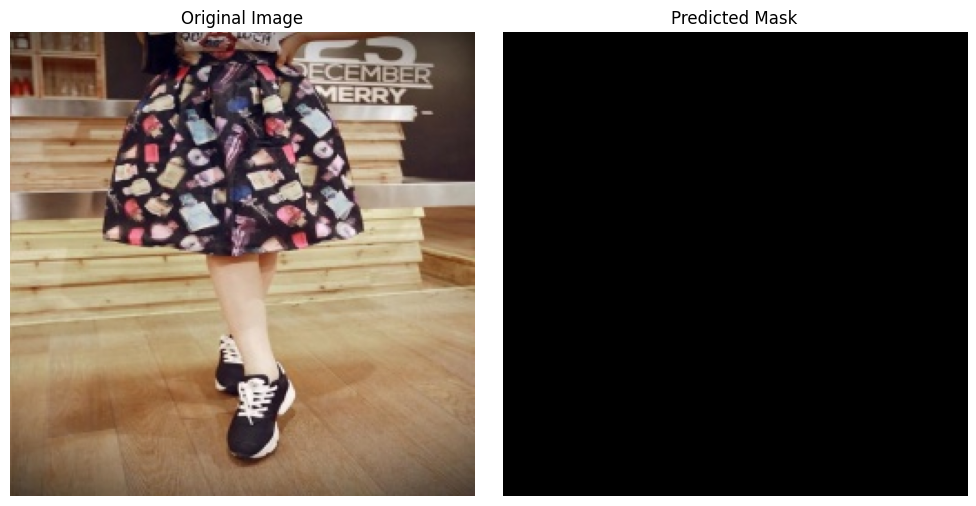

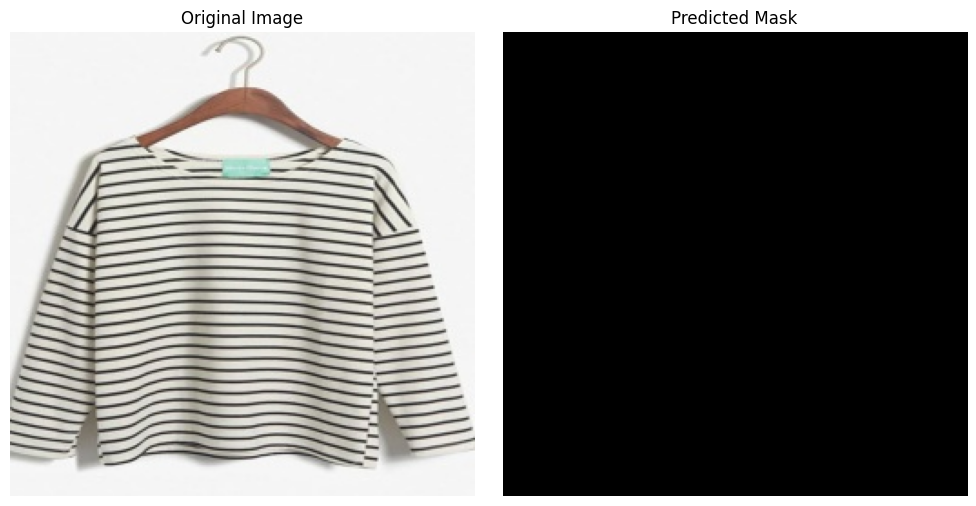

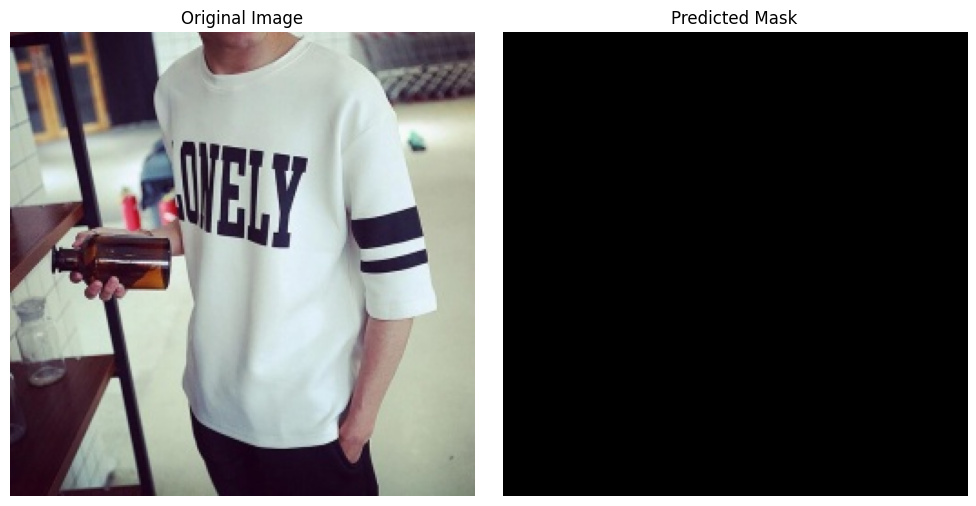

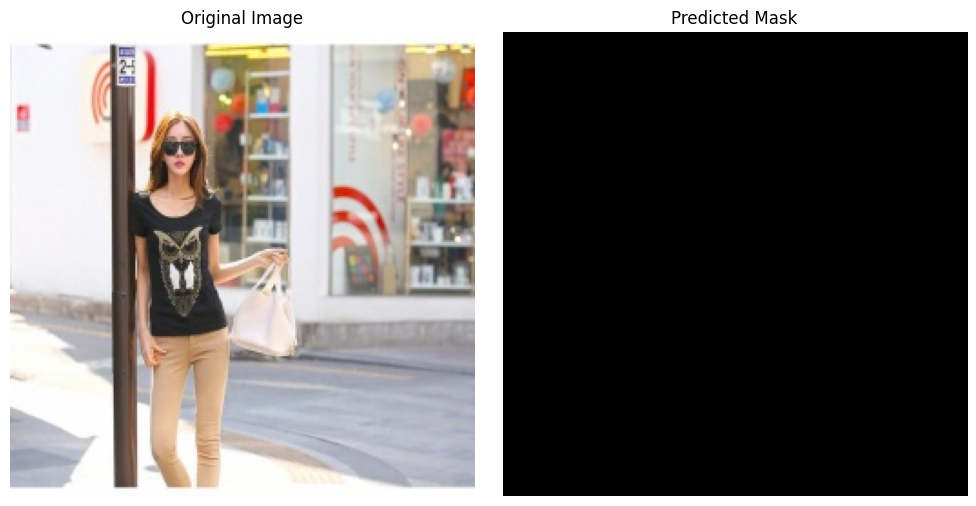

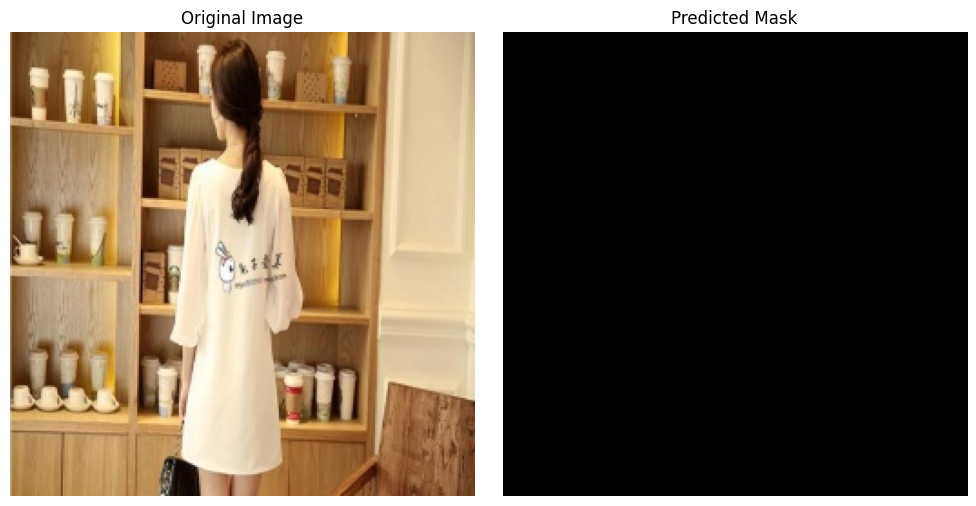

In [17]:
def visualize_predictions(input_dir, output_dir, num_images=5):
    """
    Visualize a few predictions by displaying the original image and the predicted mask.

    Args:
        input_dir (str): Path to the directory containing test images.
        output_dir (str): Path to the directory where predicted masks are saved.
        num_images (int): Number of predictions to visualize.
    """
    # Get all image files from the input directory
    image_files = [f for f in os.listdir(input_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    # Visualize predictions for the first `num_images` images
    for i, image_name in enumerate(image_files[:num_images]):
        image_path = os.path.join(input_dir, image_name)
        predicted_mask_path = os.path.join(output_dir, f"{os.path.splitext(image_name)[0]}_mask.png")

        # Load the original image and predicted mask
        original_image = Image.open(image_path).convert("RGB")
        predicted_mask = Image.open(predicted_mask_path)

        # Plot the original image and predicted mask side by side
        plt.figure(figsize=(10, 5))
        
        # Display the original image
        plt.subplot(1, 2, 1)
        plt.imshow(original_image)
        plt.title("Original Image")
        plt.axis("off")

        # Display the predicted mask
        plt.subplot(1, 2, 2)
        plt.imshow(predicted_mask, cmap="gray")
        plt.title("Predicted Mask")
        plt.axis("off")

        plt.tight_layout()
        plt.show()

# Visualize predictions
visualize_predictions(input_directory, output_directory, num_images=5)


Classification